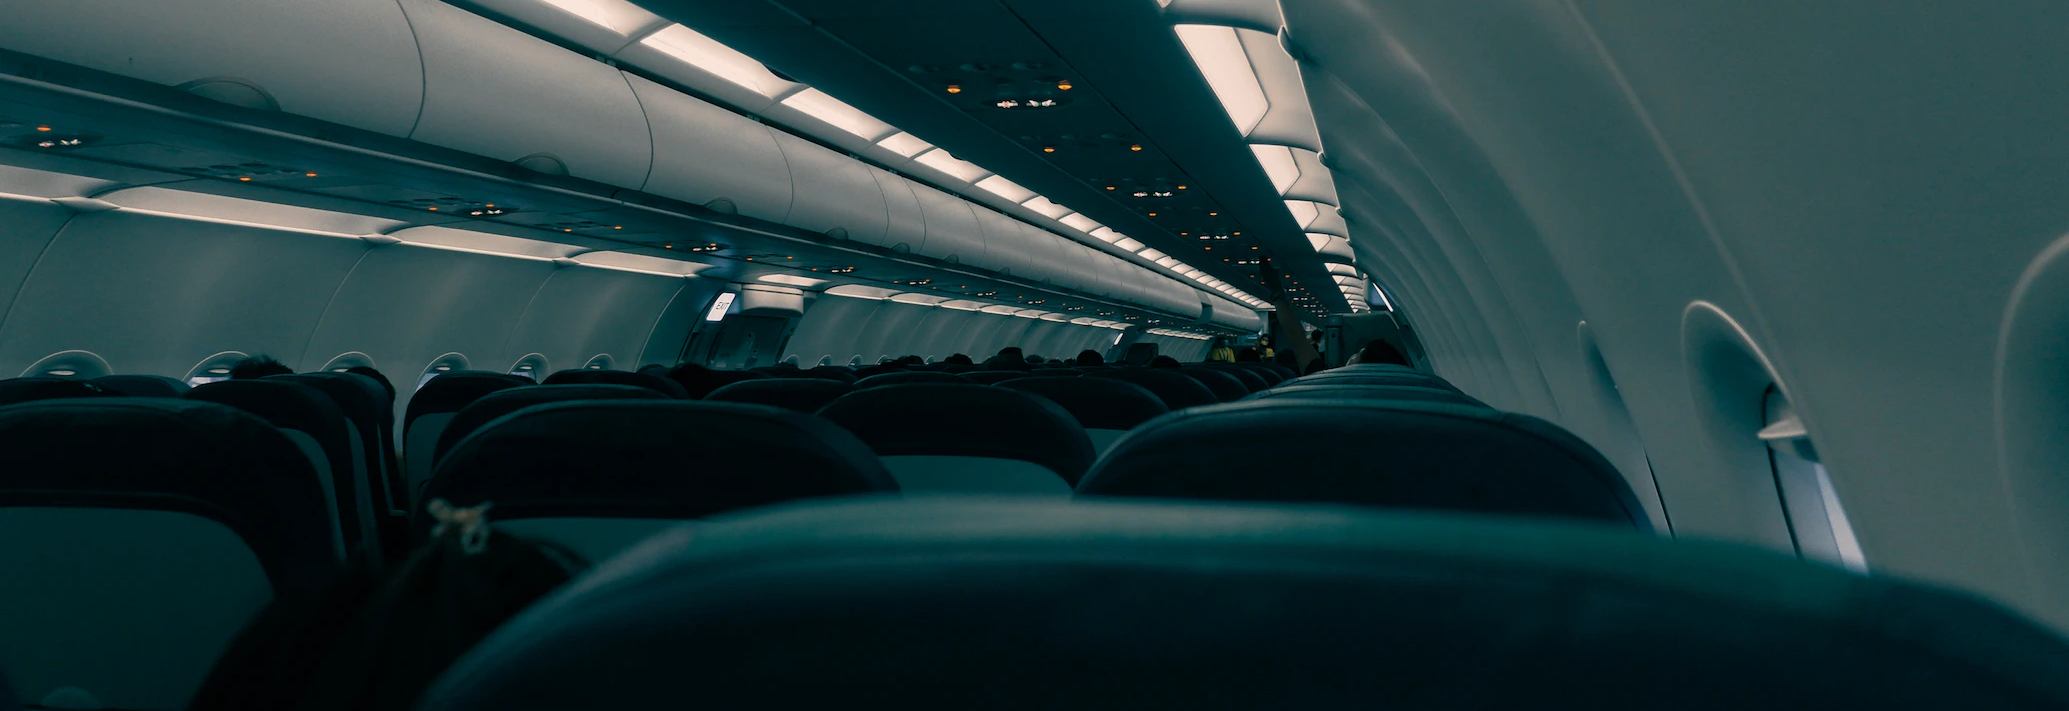
Photo by <a href="https://unsplash.com/@josonrey?utm_content=creditCopyText&utm_medium=referral&utm_source=unsplash">Rey Joson</a> on <a href="https://unsplash.com/photos/the-inside-of-an-airplane-with-the-lights-on-M8ZmpOr9Lrc?utm_content=creditCopyText&utm_medium=referral&utm_source=unsplash">Unsplash</a>

# Airline Passenger Satisfaction
Elimelech Berlin  
October 2023

***
## Overview
This report analyzes records of airline customers to construct a classification model to identify customers who are likely to be not satisfied by their experience.
Several different modeling techniques are implemented:
* Logistic Regression
* Random Forest Classifier
* CatBoost Classifier
* Voting Classifier

Ultimately, a random forest classifier is identified as the most performant model. A closer examination of that model reveals what specific factors most influence a customer's satisfaction:
* Online boarding
* Inflight wifi service
* Type of travel

By further examining these features, deeper insight into customer satisfaction is attained.

***
## Business Context
A satisfied customer is a repeat customer.  
A model capable of accurately predicting a customer's dissatisfaction can prove invaluable in equipping an airline with the necesarry insight to modify the elements of service contributing to that dissatisfaction.  
Additionally, the knowledge of which customers will likely be dissatisfied, will provide the airline with a strong basis to preemptively target whoever is predicted to be dissatisfied, thus minimizing overall customer dissatisfaction.


***
## Data
The data used in this report is from the Kaggle [Airline Passenger Satisfaction](https://www.kaggle.com/datasets/teejmahal20/airline-passenger-satisfaction?rvi=1) dataset. It contains records from an airline passenger survey with ~130k participants. Most of the features of this dataset describe subjective customer ratings of various elements of their experience, while a few features included describe certain objective elements of flight experiences (e.g. customer age, flight distance).

To gain some familiarity with the data let's have a look at it. Before we can load & examine the data, import all of the necessary libraries:

In [133]:
import zipfile
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, recall_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier
import warnings

# disable warnings
warnings.filterwarnings('ignore')

# set matplotlib.pyplot style
plt.style.use('seaborn-v0_8')

Now, load the data; it's contained in two files, train & test, located in a zipped file. (The data comes divided this way from Kaggle.)

In [16]:
# open zipped file & create a dataframe for each of the train/test subsets of the data
with zipfile.ZipFile('data/archive.zip', 'r') as zipped_file:
    for file in zipped_file.namelist():
        file_csv = zipped_file.open(file)
        file_df = pd.read_csv(file_csv)
        if file == 'test.csv':
            test_df = file_df
        if file == 'train.csv':
            train_df = file_df

To gain better understanding of the dataset, let's get a list of the dataframe's columns:

In [17]:
# list column names
train_df.columns

Index(['Unnamed: 0', 'id', 'Gender', 'Customer Type', 'Age', 'Type of Travel',
       'Class', 'Flight Distance', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes',
       'satisfaction'],
      dtype='object')

> From the above output, we infer that the target feature is `'satisfaction'` & all other features are the predictor values.

Let's now view the shape of the datasets:

In [134]:
# train set
train_df.shape

(103904, 23)

In [135]:
# test set
test_df.shape

(25976, 23)

> There are roughly 130,000 rows, described by 22 columns.

Calculate the train/test split:

In [137]:
print('This is equal to a train/test split of {}/{}'.format(int(train_df.shape[0] / (test_df.shape[0] + train_df.shape[0]) * 100), int(test_df.shape[0] / (test_df.shape[0] + train_df.shape[0]) * 100)))

This is equal to a train/test split of 80/20


Now, let's have a look at the distribution of the target feature:

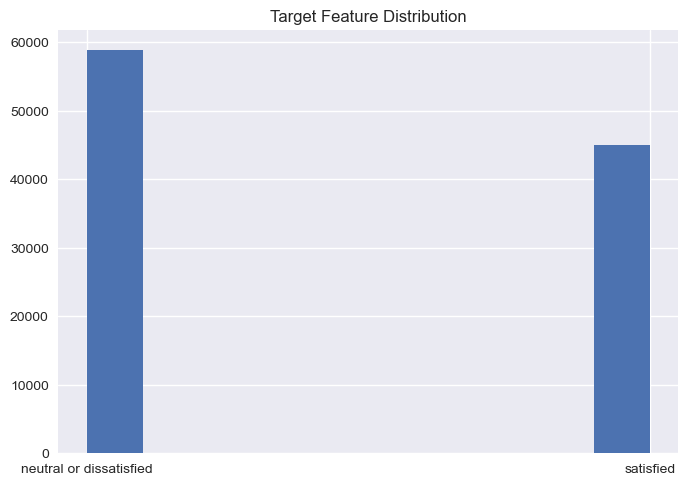

In [18]:
# plot histogram of target feature
plt.hist(train_df['satisfaction'])

plt.title('Target Feature Distribution');

> There is slight class imbalance present in the distribution of the target feature. This imbalance is not significant enough to be of concern, & no corrective action is necessary.

With the data loaded into a workable format, & having examined the data on a very basic level, we are now ready to begin preprocessing.

***
## Preprocessing
In this section we deal with null values, remove unnecessary columns & transform all of the data into numeric values.  

Let's again view the first few rows:

In [22]:
# view first 5 rows of the dataframe
train_df.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


>Two columns are clearly irrelevant to this report: `'Unnamed: 0'` & `'id'`. Let's remove them from the dataframe:

In [138]:
# remove from train set
train_df.drop(['Unnamed: 0', 'id'], axis=1, inplace=True)
# remove from test set
test_df.drop(['Unnamed: 0', 'id'], axis=1, inplace=True)

KeyError: "['Unnamed: 0', 'id'] not found in axis"

Now, check for missing values:

In [ ]:
# train subset
train_df.isna().sum()

In [ ]:
# test subset
test_df.isna().sum()

> The only column with missing values is `'Arrival Delay in Minutes'`. This cannot be understood as there being no delay for a given flight, as this would be recorded as `'0'`, as seen for many such records present in the data:

In [26]:
train_df['Arrival Delay in Minutes'].value_counts()

Arrival Delay in Minutes
0.0      58159
1.0       2211
2.0       2064
3.0       1952
4.0       1907
         ...  
458.0        1
729.0        1
382.0        1
459.0        1
369.0        1
Name: count, Length: 455, dtype: int64

> There are thousands of rows with `'0'` recorded for arrival delay, so null doesn't necasserily mean there wasn't a delay.
We will need to impute the mean of the column's values for those that are missing. 


Before implementing this, let's further examine the dataset to learn what other preprocessing steps must be executed.  
View datatypes present in the dataset:

In [27]:
train_df.dtypes

Gender                                object
Customer Type                         object
Age                                    int64
Type of Travel                        object
Class                                 object
Flight Distance                        int64
Inflight wifi service                  int64
Departure/Arrival time convenient      int64
Ease of Online booking                 int64
Gate location                          int64
Food and drink                         int64
Online boarding                        int64
Seat comfort                           int64
Inflight entertainment                 int64
On-board service                       int64
Leg room service                       int64
Baggage handling                       int64
Checkin service                        int64
Inflight service                       int64
Cleanliness                            int64
Departure Delay in Minutes             int64
Arrival Delay in Minutes             float64
satisfacti

> Several columns contain non-numeric data types. These must be modified before any attempt at modelling. Columns with binary values can be simply mapped to `'0'` or `'1'`; columns with more than 2 values must be one-hot encoded.

#### Preprocessing Pipeline
In this subsection, we construct a pipeline to streamline several preprocessing steps:  
* Imputer to fill missing values
* Convert any columns with only 2 values into a binary column
* OneHotEncode categorical columns with more than 2 values

Each of these steps is first defined in a function, & then combined into a single pipeline:

In [28]:
# define imputer function
def pd_impute(df):
    return pd.DataFrame(SimpleImputer(strategy='constant',
                                      fill_value = train_df['Arrival Delay in Minutes'].mean()).fit_transform(df),
                        columns=df.columns)

In [29]:
# define binary converter function
def binary_conv(df):
    for col in df.columns:
        if df[col].dtype == 'object' and len(df[col].unique()) == 2:
#             get new column name
            new_name = df[col].unique()[1]
#             create new column
            df[new_name] = df[col].map({df[col].unique()[0]:0, df[col].unique()[1]:1})
#            remove original column
            df.drop(col, axis=1, inplace=True)
    
    return df

In [30]:
# define one-hot-encoder function
def ohe_col(df):
    for col in df.columns:
#             set all values to numeric dtypes when possible
            df[col] = pd.to_numeric(df[col], errors='ignore')
#         select only 'object' type columns
            if df[col].dtype == 'object':
#         fit one-hot-encoder
                ohe = OneHotEncoder().fit(df[[col]])
#     create dataframe from ohe values
                new_df = pd.DataFrame(ohe.transform(df[[col]]).toarray(),
                                      columns= ohe.get_feature_names_out())
#     combine new df with old one
                newer_df = pd.concat([df, new_df], axis=1, )
#     remove original categorical column
                newer_df.drop(col, axis=1, inplace=True)
        
    return newer_df

In [31]:
# impute, one-hot encode (x2) (avoid pd.get_dummies, instead use sklearn ohe)
pipe = Pipeline([ ('binary_conv', FunctionTransformer(binary_conv)),
                  ('imputer', FunctionTransformer(pd_impute)),
                  ('ohe', FunctionTransformer(ohe_col))
                ])

With the above functions included in the pipeline, transform the two datasets:

In [32]:
# fit pipeline to the train set & create new dataframe
all_num_train_df = pipe.fit_transform(train_df)

# transform test set
all_num_test_df = pipe.transform(test_df)

Before continuing, ensure that the dataframes' column names match:

In [33]:
# ensure that columns of the 2 dataframes match
try:
    assert [col for col in all_num_train_df] == [col for col in all_num_test_df]
except:
    print("Column names don't match")

Column names don't match


> The above output tell us that the column names don't match. Have a closer look:

In [34]:
train_cols = [col for col in all_num_train_df if col not in all_num_test_df]
test_cols = [col for col in all_num_test_df if col not in all_num_train_df]

print('train columns:', train_cols)
print('test columns', test_cols)

train columns: ['Female', 'Business travel', 'satisfied']
test columns ['Male', 'Personal Travel', 'neutral or dissatisfied']


Let's convert the columns of the test set to match those of the train set:

In [35]:
for i, col in enumerate(test_cols):
    if col not in train_cols:
#         create new column w/ correct name
        all_num_test_df[train_cols[i]] = all_num_test_df[col]
#     switch positive & negative values
        all_num_test_df[train_cols[i]].replace({0:1, 1:0}, inplace=True)
#     remove original column
        all_num_test_df.drop(col, axis=1, inplace=True)

In [36]:
# ensure that columns are in the same order
all_num_test_df = all_num_test_df[all_num_train_df.columns]

Recheck for any difference in column names:

In [37]:
# ensure that columns of the 2 dataframes match
assert [col for col in all_num_train_df] == [col for col in all_num_test_df]

> The above cell runs without raising an error; the column names match.

Before moving on to the next step of our report, review final column names:

In [38]:
all_num_train_df.columns

Index(['Age', 'Flight Distance', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes',
       'Female', 'disloyal Customer', 'Business travel', 'satisfied',
       'Class_Business', 'Class_Eco', 'Class_Eco Plus'],
      dtype='object')

> The above output reveals that the column `'disloyal Customer'` describes a customer's loyalty status. To keep things as intuitive as possible, switch the column to be describing a positive state (customer loyalty) instead of a negative state (customer disloyalty).

In [39]:
# replace 'disloyal Customer' with 'Loyal Customer'
# create 'Loyal Customer' column
all_num_train_df['Loyal Customer'] = all_num_train_df['disloyal Customer'].map({0:1, 1:0})
all_num_test_df['Loyal Customer'] = all_num_test_df['disloyal Customer'].map({0:1, 1:0})

In [40]:
# view both columns to ensure the values are oppposites of each other
all_num_train_df[['disloyal Customer', 'Loyal Customer']]

,disloyal Customer,Loyal Customer
0,0,1
1,1,0
2,0,1
3,0,1
4,0,1
...,...,...
103899,1,0
103900,0,1
103901,1,0
103902,1,0


In [42]:
# remove 'disloyal Customer' column
# train set
all_num_train_df.drop('disloyal Customer', axis=1, inplace=True)

# test set
all_num_test_df.drop('disloyal Customer', axis=1, inplace=True)

With the data loaded, all null values removed,  & all converted into numeric form, we are now ready to move on to the next step of this report: EDA.

***
## EDA
In this section we explore the various features present in the dataset, identifying the level of correlation amongst all of the features. We also explore the target variable's to some of the more relevant predictors.

To check data for any obvious patterns or autocorrelation, view a corellation heatmap:

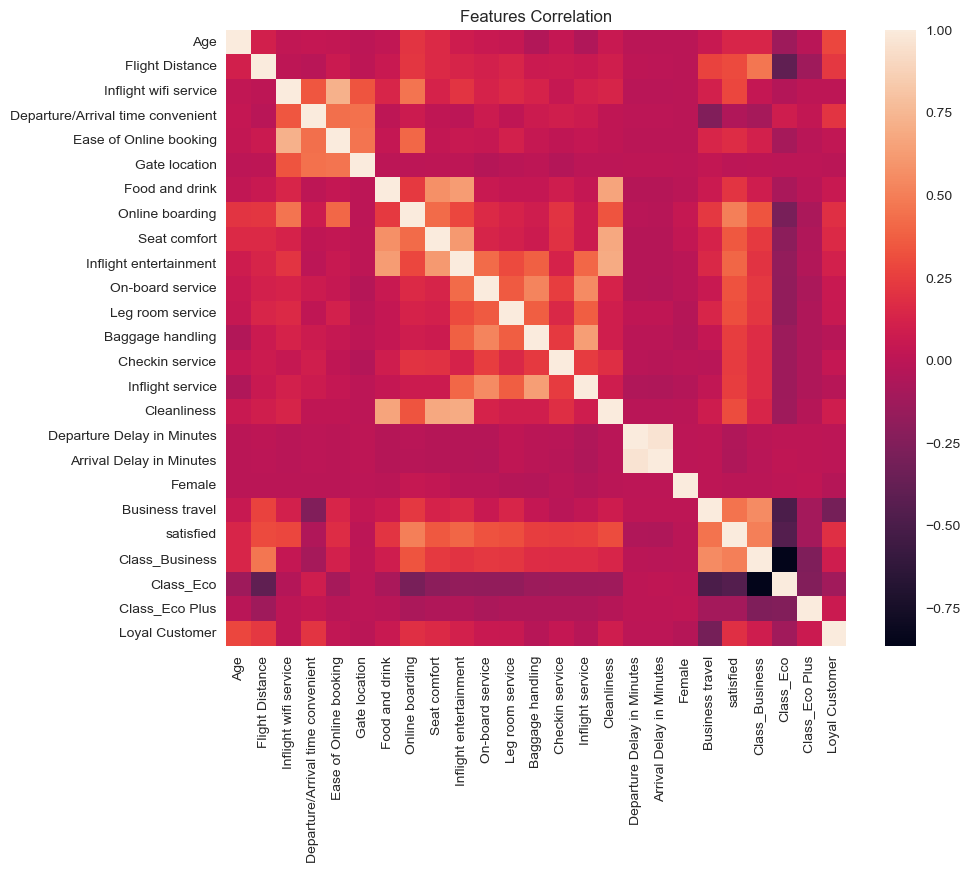

In [43]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(all_num_train_df.corr())
ax.set_title('Features Correlation');

> The above plot shows that, unsurprisingly, there is strong correlation between `'Departure Delay in Minutes'` & `'Arrival Delay in Minutes'`. Let's examine their correlation:

In [44]:
all_num_train_df.corr()['Departure Delay in Minutes']['Arrival Delay in Minutes']

0.9611607683973858

> Indeed, the two are closely correlated. To avoid any issues in modeling arising from this, let's remove one of those columns. Let's drop the one that has a weaker correlation with `'satisfied'`.

In [45]:
[{col : all_num_train_df.corr()['satisfied'][col]} for col in all_num_train_df.columns if 'Delay' in col]

[{'Departure Delay in Minutes': -0.050494210261235115},
 {'Arrival Delay in Minutes': -0.057496815057623676}]

> `'Arrival Delay in Minutes'` has slightly greater correlation with `'satisfied'` than `'Departure Delay in Minutes'`; drop `'Departure Delay in Minutes'` column from the dataframe:

In [46]:
# train test
all_num_train_df.drop(['Departure Delay in Minutes'], axis=1, inplace=True)
# test set
all_num_test_df.drop(['Departure Delay in Minutes'], axis=1, inplace=True)

Let's now visualize each predictor's correlation to the the target feature:

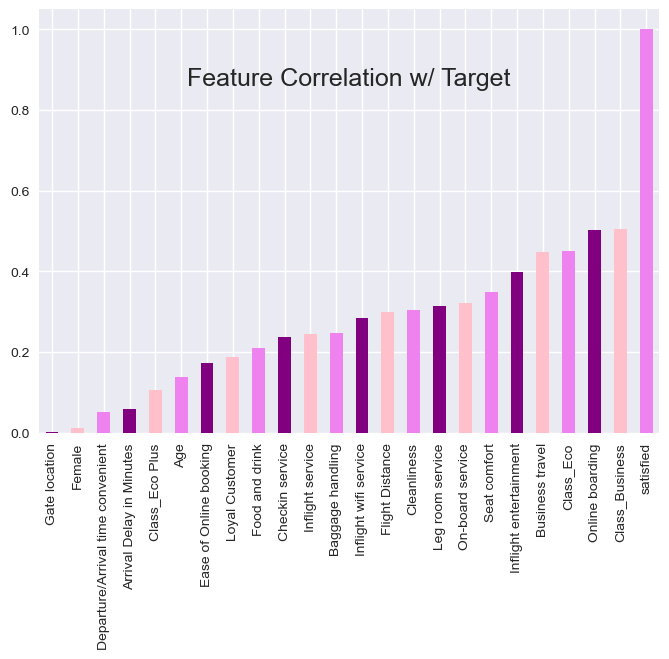

In [47]:
# view ordered list of features with their correlation to 'satisfied'
all_num_train_df.corr()['satisfied'].abs().sort_values().plot(kind='bar', color=['purple', 'pink', 'violet'])
plt.title("Feature Correlation w/ Target", fontsize=18, y=.8);

> The above plot reveals which features have the strongest relationship with the target feature `satisfied`. Let's visualize the top 3:
* Class
* Online Boarding
* Business Travel

Visualize a barplot showing the satisfaction by class:

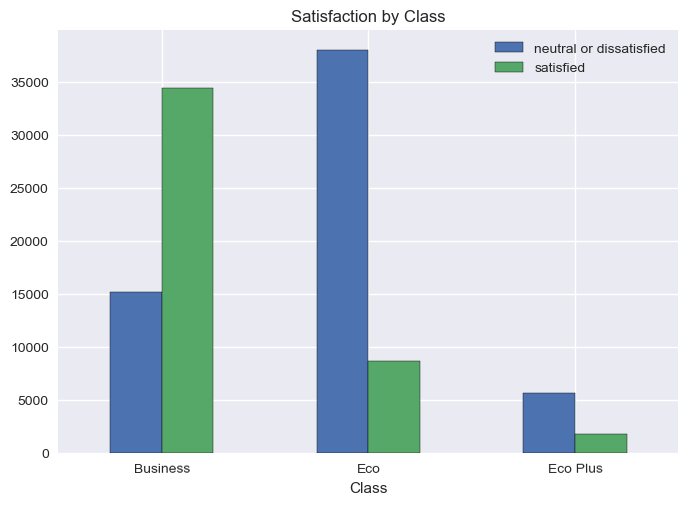

In [48]:
# plot satisfaction by class (easier to use non-numeric dataframe)
train_df[['Class', 'satisfied']].replace({0:'neutral or dissatisfied', 1:'satisfied'}).value_counts().unstack().plot(kind='bar', edgecolor='black')
plt.title('Satisfaction by Class')
plt.legend()
plt.xticks(rotation=.45);

> A clear pattern of greater satisfaction for higher classes is apparent.

View satisfaction by by Online Boarding rating:

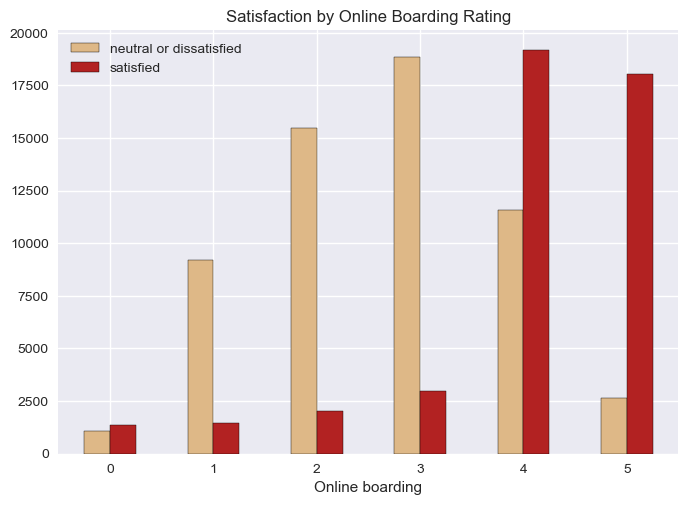

In [49]:
all_num_train_df.groupby('Online boarding')['satisfied'].value_counts().unstack().plot(kind='bar', edgecolor='black', color=['burlywood', 'firebrick'])
plt.title('Satisfaction by Online Boarding Rating')
plt.legend(['neutral or dissatisfied', 'satisfied'])
plt.xticks(rotation=.9);

>We see that customers who feel good  (4 or 5) about their online boarding experience, tend to be satisfied. (Note the drastic difference between columns 3 & 4.)

Now, let's have a look at `'satisfaction'` according to type of travel:

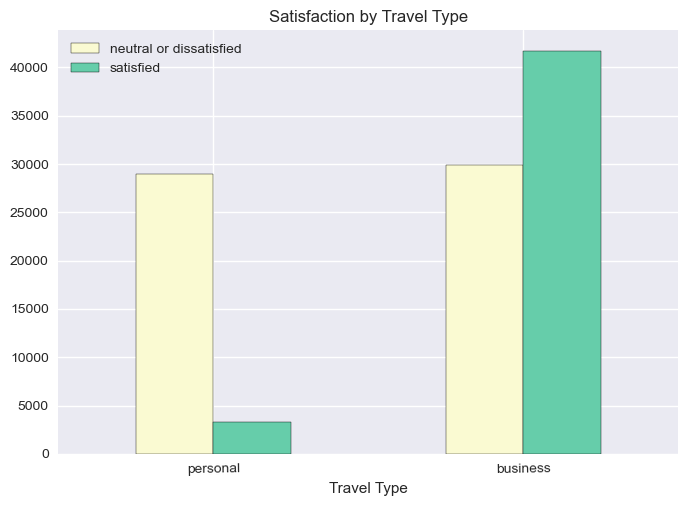

In [50]:
all_num_train_df[['Business travel', 'satisfied']].value_counts().unstack().plot(kind='bar', edgecolor='black', color=['lightgoldenrodyellow', 'mediumaquamarine'])
plt.title('Satisfaction by Travel Type')
plt.legend(['neutral or dissatisfied', 'satisfied'])
plt.xlabel('Travel Type')
plt.xticks([0, 1], ['personal', 'business'], rotation=.9);

> A strong discrepancy in satisfaction levels between types of travelers is visible.

***
#### Preprocessing Final Steps
Because the range of values found in each of the columns is inconsistent, the values need to be scaled before modeling.
The following code does so, & also excludes the target feature from the new dataframes.

In [51]:
# instantiate scaler
scaler = StandardScaler()

# fit & transform training data
X_train_scaled = pd.DataFrame(scaler.fit_transform(all_num_train_df.drop(['satisfied'], axis=1)), columns = all_num_train_df.drop(['satisfied'], axis=1).columns)

# transform test data
X_test_scaled = pd.DataFrame(scaler.transform(all_num_test_df.drop(['satisfied'], axis=1)), columns = all_num_train_df.drop(['satisfied'], axis=1).columns)

Store the target feaure as a seperate variable (a DataFrame) & be sure to correctly set the datatype:

In [52]:
# train
y_train = all_num_train_df[['satisfied']].astype('int')

# test
y_test = all_num_test_df[['satisfied']].astype('int')

### EDA Summary
We have seen the correlation between the target feature `'satisfaction'` & the other featuers in the dataset. After having examined the distribution of those features most correlated with the target & gained some intuition into their relationship with visualizations, we are now ready to proceed with modeling the data.


## Modeling
In this section, the data is modeled in several different ways:
* Dummy Classifier
* Logistic Regression Classifier
* Random Forest Classifier
* CatBoost Classifier
* Voting Classifier  

The performance of each model is assessed by:
* Generating predictions for the train & test set
* Viewing a classification report for each set of predictions
* Visuaizing models predictive ability through a heatmap

After the above methods are applied, the most performant model is tuned to improve its performance.

### Dummy Classifier
We begin the modeling section of this report with a dummy classifier.
> This classifier doesn't really learn anything from the predictor features, it simply classifies every record as belonging to the majority class. The point of using such a model is to establish a baseline against which to assess all subsequent models, therefore, this model uses only the 3 most correlated predictor features in its 'predictions'.  

First, create a dataframe containing only the three most correlated features. To do so, begin by creating a list of those features:

In [53]:
# create a dictionary of with feature names as keys & their correlation with target as values
corr_dict = {}

for col in X_train_scaled.columns:
    corr_dict[col] = abs(all_num_train_df.corr()['satisfied'][col])
    
# get 3 most correlated features 
top_corr = [x for x, y in sorted(corr_dict.items(), key = lambda x: x[1])[-3:]]

# view feature names
top_corr

['Class_Eco', 'Online boarding', 'Class_Business']

Use the above list to create the train & test dataframes:

In [54]:
# train dataframe
high_corr_df_train = all_num_train_df[top_corr]

# test dataframe
high_corr_df_test = all_num_test_df[top_corr]

Now, instantiate & fit the model to the train set:

In [55]:
# instantiate model
dummy_classifier = DummyClassifier(random_state=42)

# fit model to training data
dummy_classifier.fit(high_corr_df_train, y_train)

DummyClassifier(random_state=42)

Generate predictions:

In [56]:
# generate predictions
# train set
dummy_train_predict = dummy_classifier.predict(high_corr_df_train)

# test_set
dummy_test_predict = dummy_classifier.predict(high_corr_df_test)

#### Model Evaluation
>The business case considered for this report dictates that model performance be measured by it's ability to find those who will not be satisfied, thus __recall for class `'0'`__ (neutral or dissatisfied) is the primary metric of focus.

The following steps are followed to evaluate this model's performance:
* View a classification report for each set of predictions
* Visualize model's predictive ability with a heatmap
* Summarize

View classification report for each data subset:

In [57]:
# generate train set classification report
pd.DataFrame(classification_report(y_train, dummy_train_predict, output_dict=True, zero_division= 0))

,0,1,accuracy,macro avg,weighted avg
precision,0.566667,0.0,0.566667,0.283334,0.321112
recall,1.000000,0.0,0.566667,0.500000,0.566667
f1-score,0.723405,0.0,0.566667,0.361702,0.409930
support,58879.000000,45025.0,0.566667,103904.000000,103904.000000


In [58]:
# generate test set classification report
pd.DataFrame(classification_report(y_test, dummy_test_predict, output_dict=True, zero_division= 0))

,0,1,accuracy,macro avg,weighted avg
precision,0.561018,0.0,0.561018,0.280509,0.314741
recall,1.000000,0.0,0.561018,0.500000,0.561018
f1-score,0.718785,0.0,0.561018,0.359392,0.403251
support,14573.000000,11403.0,0.561018,25976.000000,25976.000000


Finally, visualize the model's performance on the test set with a heatmap:

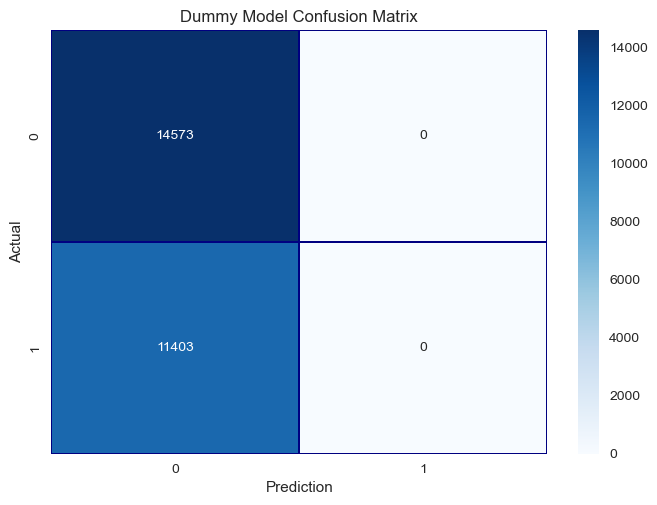

In [120]:
sns.heatmap(confusion_matrix(y_test, dummy_test_predict), annot=True, linewidths = .2, fmt='d', linecolor='navy', cmap='Blues')
plt.title('Dummy Model Confusion Matrix')
plt.xlabel('Prediction')
plt.ylabel('Actual');

> The above plot shows us the unsurprising result of our dummy classifier: the model scores a perfect recall of 1, but at the price of only 56% accuracy. This is because the model classifies every sample as the majority class, which in this case is 0 (neutral or dissatisfied).

### Logistic Regression
The next modeling algorithm used is logistic regression.
> Though not truly a classifier, this algoritm classifies each input by generating the probability of a given input belonging to either class, & classifies it accordingly.

In [60]:
# instantiate model
log_reg = LogisticRegression(random_state=42)

# fit model to training data
log_reg.fit(X_train_scaled, np.array(y_train).ravel())

LogisticRegression(random_state=42)

Generate predictions:

In [61]:
# train predictions
log_train_predict = log_reg.predict(X_train_scaled)

# test predictions
log_test_predict =log_reg.predict(X_test_scaled)

#### Model Evaluation
The following steps are followed to evaluate this model's performance:
* View a classification report for each set of predictions
* Visualize model's predictive ability with a heatmap
* Summarize

View classification report for each data subset:

In [62]:
# generate train set classification report
pd.DataFrame(classification_report(y_train, log_train_predict, output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.878574,0.870476,0.875202,0.874525,0.875065
recall,0.904822,0.836469,0.875202,0.870645,0.875202
f1-score,0.891505,0.853133,0.875202,0.872319,0.874877
support,58879.000000,45025.000000,0.875202,103904.000000,103904.000000


In [63]:
# generate test set classification report
pd.DataFrame(classification_report(y_test, log_test_predict, output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.873107,0.869004,0.871381,0.871055,0.871306
recall,0.901805,0.832500,0.871381,0.867152,0.871381
f1-score,0.887224,0.850361,0.871381,0.868792,0.871041
support,14573.000000,11403.000000,0.871381,25976.000000,25976.000000


Finally, visualize the model's performance on the test set with a heatmap:

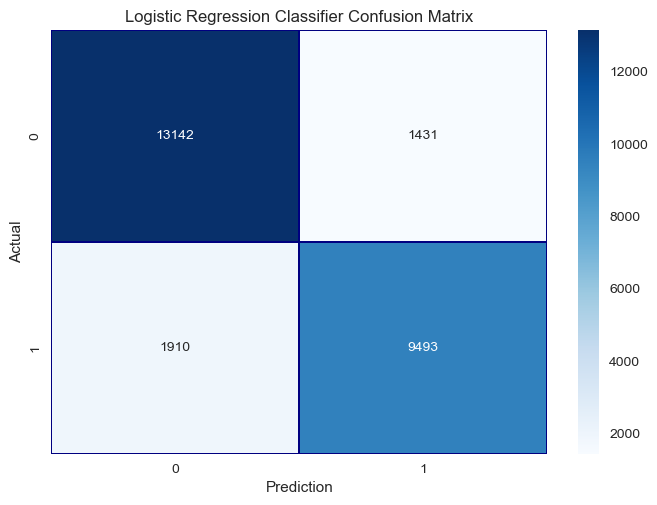

In [64]:
# plot heatmap
sns.heatmap(confusion_matrix(y_test, log_test_predict), annot=True, linewidths = .2, fmt='d', linecolor='navy', cmap='Blues')
plt.title('Logistic Regression Classifier Confusion Matrix')
plt.xlabel('Prediction')
plt.ylabel('Actual');

> The above plot shows that the model perform on the test set, nearly as well as it did on the train set. For both subsets of the data, the model scored a recall of .9 in idendetifying customers of class `'0'`. The other metrics were only slightly worse with values between 83-87.

Let's see if we can get better performance by adjusting the model's 'C' hyperparameter. Let's do this using GridSearchCV:

In [108]:
# define the grid
log_grid = {'C': [1000, 100000, 1000000, 100000000]}

In [109]:
# instantiate the model
gs_cv = GridSearchCV(log_reg, log_grid, scoring='recall', return_train_score=True)

In [110]:
# fit to the training data
gs_cv.fit(X_train_scaled, np.array(y_train).ravel())

GridSearchCV(estimator=LogisticRegression(random_state=42),
             param_grid={'C': [1000, 100000, 1000000, 100000000]},
             return_train_score=True, scoring='recall')

In [115]:
gs_cv.best_params_

{'C': 1000}

In [127]:
# instantiate model
log_reg_2 = LogisticRegression(C = 1000, random_state=42)

# fit model to training data
log_reg_2.fit(X_train_scaled, np.array(y_train).ravel())

LogisticRegression(C=1000, random_state=42)

Generate predictions:

In [128]:
# train predictions
log_2_train_predict = log_reg_2.predict(X_train_scaled)

# test predictions
log_2_test_predict =log_reg_2.predict(X_test_scaled)

#### Model Evaluation
The following steps are followed to evaluate this model's performance:
* View a classification report for each set of predictions
* Visualize model's predictive ability with a heatmap
* Summarize

View classification report for each data subset:

In [129]:
# generate train set classification report
pd.DataFrame(classification_report(y_train, log_2_train_predict, output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.878574,0.870476,0.875202,0.874525,0.875065
recall,0.904822,0.836469,0.875202,0.870645,0.875202
f1-score,0.891505,0.853133,0.875202,0.872319,0.874877
support,58879.000000,45025.000000,0.875202,103904.000000,103904.000000


In [130]:
# generate test set classification report
pd.DataFrame(classification_report(y_test, log_2_test_predict, output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.873049,0.868992,0.871343,0.871020,0.871268
recall,0.901805,0.832413,0.871343,0.867109,0.871343
f1-score,0.887194,0.850309,0.871343,0.868751,0.871002
support,14573.000000,11403.000000,0.871343,25976.000000,25976.000000


Finally, visualize the model's performance on the test set with a heatmap:

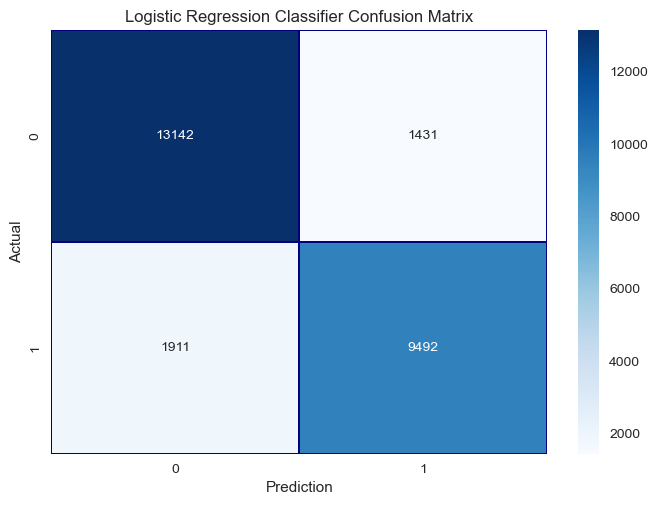

In [131]:
# plot heatmap
sns.heatmap(confusion_matrix(y_test, log_2_test_predict), annot=True, linewidths = .2, fmt='d', linecolor='navy', cmap='Blues')
plt.title('Logistic Regression Classifier Confusion Matrix')
plt.xlabel('Prediction')
plt.ylabel('Actual');

> With essentially identical results as the original logistic regression model, tuning the 'C' hyperparameter does nothing to improve the model's performance.

### Random Forest Classifier
We now use am ensemble algorithm to model the data: Random Forest Classifier.
> This algorithm harnesses the power of many decision trees to generate its predictions.

In [68]:
# instantiate model
rfc = RandomForestClassifier(random_state=42)

# fit model to training data
rfc.fit(X_train_scaled, np.array(y_train).ravel())

RandomForestClassifier(random_state=42)

Generate predictions:

In [69]:
# train predictions
rfc_train_predict = rfc.predict(X_train_scaled)

# test predictions
rfc_test_predict = rfc.predict(X_test_scaled)

#### Model Evaluation
The following steps are followed to evaluate this model's performance:
* View a classification report for each set of predictions
* Visualize model's predictive ability with a heatmap
* Summarize

View classification report for each data subset:

In [70]:
# generate train set classification report
pd.DataFrame(classification_report(y_train, rfc_train_predict, output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.999966,1.000000,0.999981,0.999983,0.999981
recall,1.000000,0.999956,0.999981,0.999978,0.999981
f1-score,0.999983,0.999978,0.999981,0.999980,0.999981
support,58879.000000,45025.000000,0.999981,103904.000000,103904.000000


In [71]:
# generate test set classification report
pd.DataFrame(classification_report(y_test, rfc_test_predict, output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.955374,0.971498,0.962234,0.963436,0.962452
recall,0.978385,0.941594,0.962234,0.959990,0.962234
f1-score,0.966742,0.956313,0.962234,0.961528,0.962164
support,14573.000000,11403.000000,0.962234,25976.000000,25976.000000


Finally, visualize the model's performance on the test set with a heatmap:

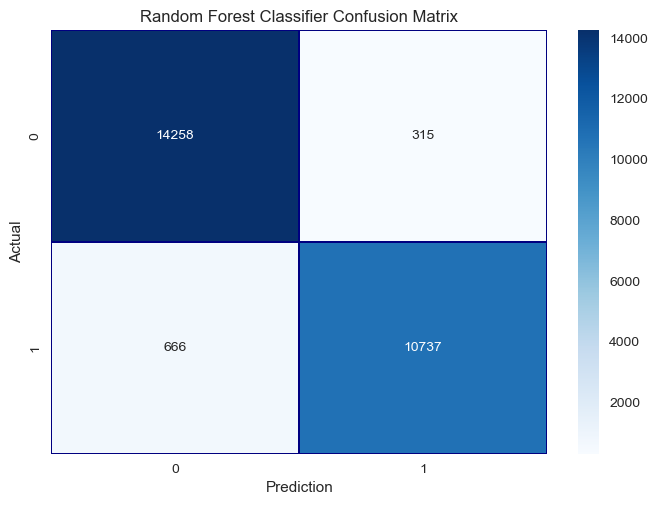

In [72]:
# plot heatmap
sns.heatmap(confusion_matrix(y_test, rfc_test_predict), annot=True, linewidths = .2, fmt='d', linecolor='navy', cmap='Blues')
plt.title('Random Forest Classifier Confusion Matrix')
plt.xlabel('Prediction')
plt.ylabel('Actual');

> The above plots show that this model performed just about perfectly on the train set. It is slightly overfit on that subset of the data, as it scored  'just' .97 for recall on the test set (class `'0'`). With overall accuracy of .96 this model performed fairly well.

#### CatBoost Classifier
Here we use a gradient boosting algorithm to model the data: CatBoost Classifier, a classifier that uses advanced gradient boosting algorithm (based on descision trees)

In [73]:
# instantiate the model
cb_model = CatBoostClassifier(iterations=2,
                           depth=2,
                           learning_rate=1,
                           loss_function='Logloss',
                           verbose=True,
                           random_state= 42)

# fit the model to the training data
cb_model.fit(X_train_scaled, y_train)

0:	learn: 0.4137249	total: 74.1ms	remaining: 74.1ms
1:	learn: 0.3176832	total: 85.3ms	remaining: 0us


Generate predictions:

In [74]:
# train set
cb_train_predict = cb_model.predict(X_train_scaled)

# test

cb_test_predict = cb_model.predict(X_test_scaled)

#### Model Evaluation
The following steps are followed to evaluate this model's performance:
* View a classification report for each set of predictions
* Visualize model's predictive ability with a heatmap
* Summarize

View classification report for each data subset:

In [75]:
# generate train set classification report
pd.DataFrame(classification_report(y_train, cb_train_predict, output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.902718,0.864925,0.886174,0.883822,0.886341
recall,0.895650,0.873781,0.886174,0.884716,0.886174
f1-score,0.899170,0.869331,0.886174,0.884251,0.886240
support,58879.000000,45025.000000,0.886174,103904.000000,103904.000000


In [76]:
# generate test set classification report
pd.DataFrame(classification_report(y_test, cb_test_predict, output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.899627,0.865883,0.884701,0.882755,0.884814
recall,0.894257,0.872490,0.884701,0.883373,0.884701
f1-score,0.896934,0.869174,0.884701,0.883054,0.884748
support,14573.000000,11403.000000,0.884701,25976.000000,25976.000000


Finally, visualize the model's performance on the test set with a heatmap:

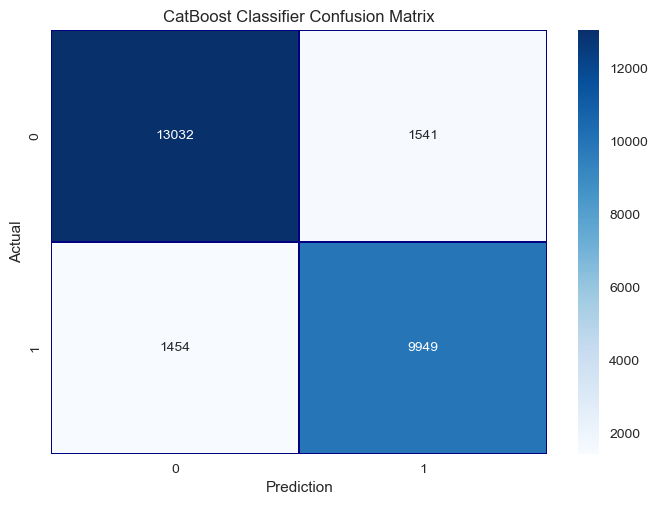

In [77]:
# plot heatmap
sns.heatmap(confusion_matrix(y_test, cb_test_predict), annot=True, linewidths = .2, fmt='d', linecolor='navy', cmap='Blues')
plt.title('CatBoost Classifier Confusion Matrix')
plt.xlabel('Prediction')
plt.ylabel('Actual');

> With minimal difference in the classification report of the two data subsets, this model isin't overfit on the training data at all. The recall of this model's performance is .89, which is only slightly higher than the other metrics that are all in the upper eighties.

### Voting Classifier
Now, use Voting Classifier, to construct a model whose predictions result from a combination of each of the previously used models (each model submits a vote for each entry, the class with the majority votes, 'wins'):

In [78]:
# instantiate the model
vc_model = VotingClassifier([('log_reg', log_reg), ('rfc', rfc), ('cb', cb_model)])

# fit to the raining data
vc_model.fit(X_train_scaled, np.array(y_train).ravel()) 

0:	learn: 0.4137249	total: 10.3ms	remaining: 10.3ms
1:	learn: 0.3176832	total: 19.5ms	remaining: 0us


VotingClassifier(estimators=[('log_reg', LogisticRegression(random_state=42)),
                             ('rfc', RandomForestClassifier(random_state=42)),
                             ('cb',
                              <catboost.core.CatBoostClassifier object at 0x000002CB2DFEC790>)])

In [79]:
# train predictions
vc_train_predict = vc_model.predict(X_train_scaled)

# test predictions
vc_test_predict = vc_model.predict(X_test_scaled)

#### Model Evaluation
The following steps are followed to evaluate this model's performance:
* View a classification report for each set of predictions
* Visualize model's predictive ability with a heatmap
* Summarize

View classification report for each data subset:

In [80]:
# generate train set classification report
pd.DataFrame(classification_report(y_train, vc_train_predict, output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.954516,0.940064,0.94825,0.947290,0.948254
recall,0.954143,0.940544,0.94825,0.947344,0.948250
f1-score,0.954330,0.940304,0.94825,0.947317,0.948252
support,58879.000000,45025.000000,0.94825,103904.000000,103904.000000


In [81]:
# generate test set classification report
pd.DataFrame(classification_report(y_test, vc_test_predict, output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.944425,0.930510,0.938328,0.937468,0.938317
recall,0.945722,0.928878,0.938328,0.937300,0.938328
f1-score,0.945073,0.929694,0.938328,0.937383,0.938322
support,14573.000000,11403.000000,0.938328,25976.000000,25976.000000


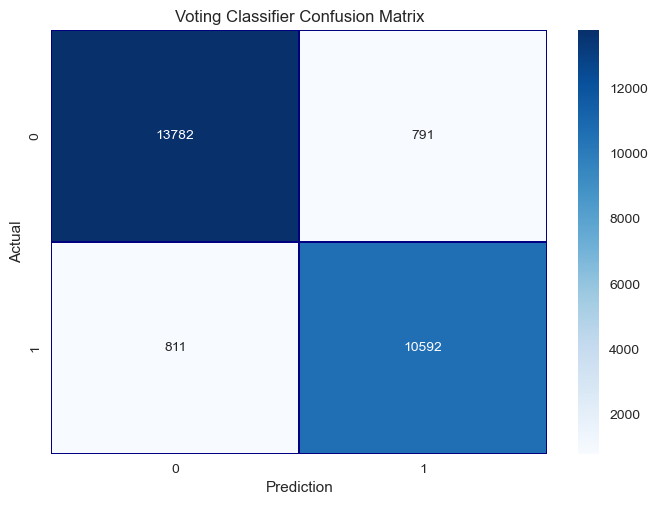

In [82]:
# plot heatmap
sns.heatmap(confusion_matrix(y_test, vc_test_predict), annot=True, linewidths = .2, fmt='d', linecolor='navy', cmap='Blues')
plt.title('Voting Classifier Confusion Matrix')
plt.xlabel('Prediction')
plt.ylabel('Actual');

> The recall for class `'0'` of the test set is only slightly lower at 94 than the train set's 95. The rest of the metrics are all only slightly lower in the mid-low nineties.

### Features
Of the above models, the Random Forest Classifier scored the highest recall for the test set at .97. Let's have a closer look at the model to gain insight into what factors most influence that classification model's predictions. To do so, plot the Random Forest Classifier model's feature importances:

First, create a list of tuple pairs, with the feature name & its importance in each pair, ordered by feature importance:

In [83]:
# create tuple pairs list
feat_imp_list = sorted(list(zip(list(X_train_scaled.columns), list(rfc.feature_importances_))),
                       key = lambda x: x[1], reverse = True)

Plot them:

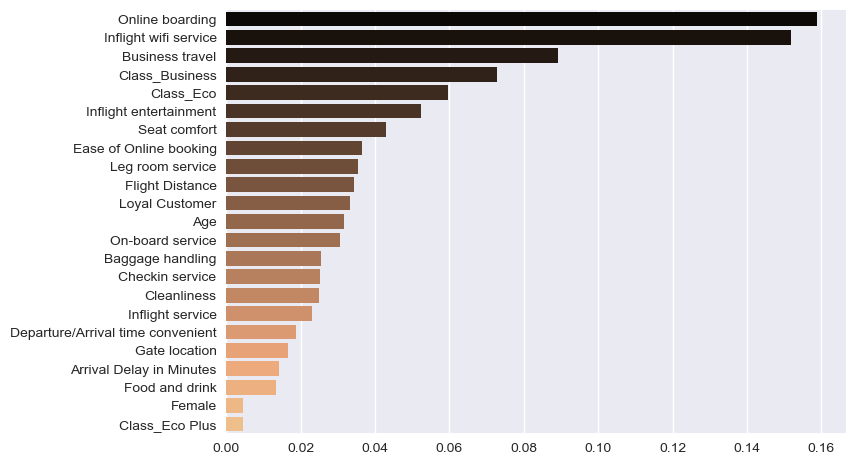

In [132]:
# plot each feature with its importance
sns.barplot(y = [x[0] for x in feat_imp_list], x = [x[1] for x in feat_imp_list], palette = 'copper');

> The above plot makes clear what the 3 most important features are:
* Online boarding
* Inflight wifi service
* Business travel (i.e. type of travel)

Let's have a look at the relationship between these features & the target feature, `'satisfied'`.  
First, view a plot of staisfied according to online boarding rating:

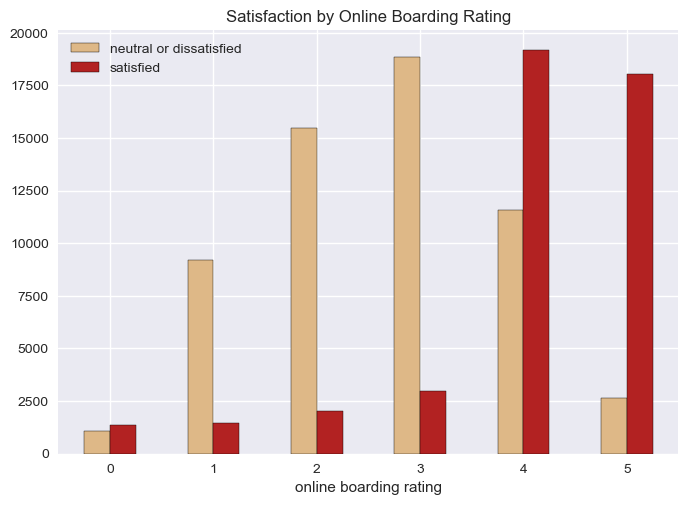

In [85]:
# plot satisfied by online boarding
all_num_train_df.groupby('Online boarding')['satisfied'].value_counts().unstack().plot(kind='bar', edgecolor='black', color=['burlywood', 'firebrick'])
plt.title('Satisfaction by Online Boarding Rating')
plt.legend(['neutral or dissatisfied', 'satisfied'])
plt.xlabel('online boarding rating')
plt.xticks(rotation=.9);

> The percentage of satisfied customers rises as their rating of online boarding does; note the extreme jump in the percentage of satisfied customers over 3.

Next, visualize wifi service ratings' relationship with satisfaction:

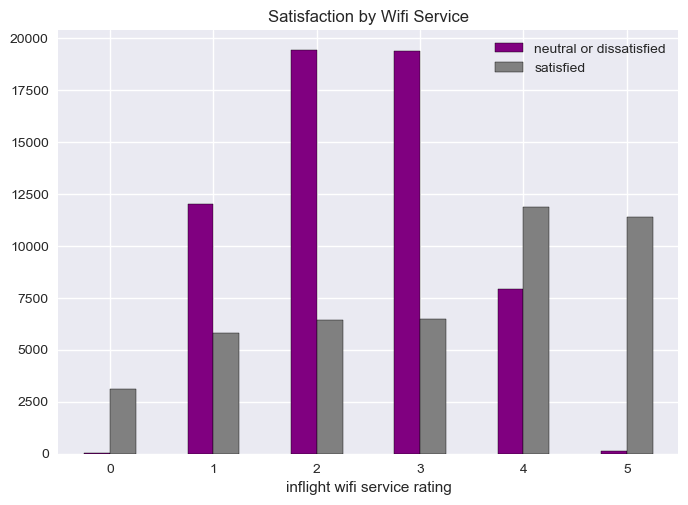

In [86]:
# plot satisfied by wifi service
all_num_train_df.groupby('Inflight wifi service')['satisfied'].value_counts().unstack().plot(kind='bar', edgecolor='black', color=['purple', 'gray'])
plt.title('Satisfaction by Wifi Service')
plt.legend(['neutral or dissatisfied', 'satisfied'])
plt.xlabel('inflight wifi service rating')
plt.xticks(rotation=.9);

> There is a clear pattern of increased customer satisfaction as ratings for wifi service increase.

Finally, visualize `'satisfied'` by type of travel:

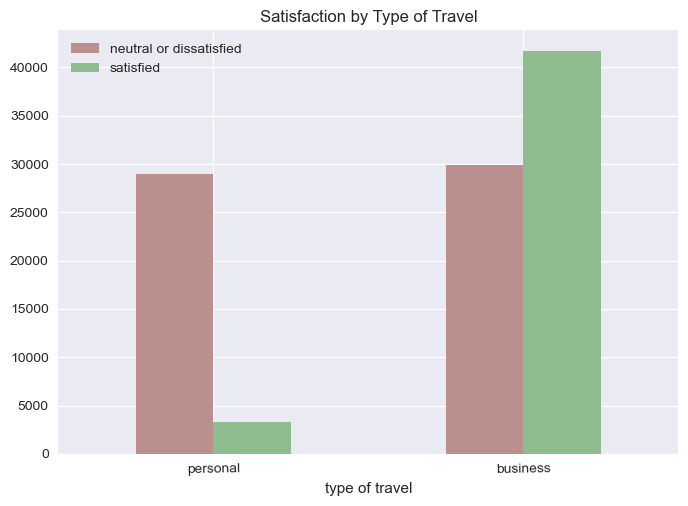

In [87]:
# plot satisfied by type of travel
all_num_train_df.groupby('Business travel')['satisfied'].value_counts().unstack().plot(kind='bar', color = ['rosybrown', 'darkseagreen'])
plt.title('Satisfaction by Type of Travel')
plt.legend(['neutral or dissatisfied', 'satisfied'])
plt.xlabel('type of travel')
plt.xticks([0, 1], ['personal', 'business'], rotation=.9);

> There is a drastic difference between the percentage of those who travel for personal reasons who are satisfied, & those who travel for business.

The following plot shows the distribution of class of travel according to type of travel. Although this does not directly relate to satisfaction, it may lend insight to the underlying cause of dissatisfaction of certain types of travelers (_see below in the Recommendations section_).

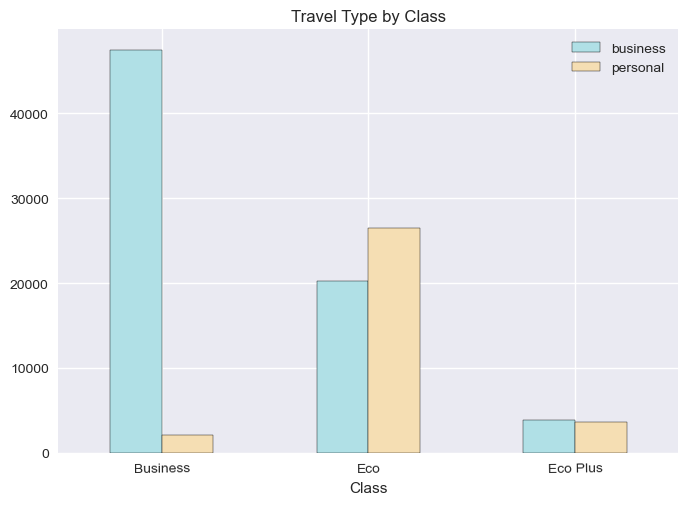

In [88]:
# plot class of travel by type of travel
train_df[['Class', 'Business travel']].replace({0:'personal', 1:'business'}).value_counts().unstack().plot(kind='bar', edgecolor='black', color=['powderblue', 'wheat'])
plt.title('Travel Type by Class')
plt.legend('reason for travel', labels=['business', 'personal'])
plt.xticks(rotation=.90);

## Recommendations
From the above plots, the following recommendations emerge:
* As seen from the plot displaying customer satisfaction according to ratings of the airlines online boarding experience, there is a strong pattern of increased satisfaction as a customer's rating of the online boarding process increases. This dictates that the airline must do its utmost in providing a great online boarding experience (e.g. intuitive interface etc.).
* From the visualization showing satisfaction according to rating of wifi service, it's apparent that customers who rate that service at 4 or 5-stars are far more likely to be satisfied overall. It is therefore important for the airline to offer strong, fast & reliable wifi service at a price acceptable to its passengers.
* Satisfaction amongst business passengers is far higher than it is amongst those who travel for personal reasons. While the reason for this is not immediately clear, this may be because business travelers tend to fligh at business class in far greater numbers than do those traveling for personal reasons (see plot above). If this is found to be so, airlines should improve the service/amenities available to all travelers, regardless of class, to boost the overall satisfaction rate.

## Limitations / Next Steps
Th following points should be taken into consideration:
* Much of the information in the dataset used, consists of ratings for a variety of elements of the customer experience. This kind of information is limited in the level of insight it provides in understanding the true motivation of customer dissatisfaction. Data consisting of text-based reviews would provide a more accurate depiction of customer feelings. Further research can be done to obtain such information.
* Additional tuning of hyperparameters may yield a better result.
* The business case for which this report was compiled dictates that recall for the negative class (neutral or dissatisfied), be the metric by which the models are evaluated. A different business context may demand a different metric.